# Exercise 01


## Exercise 01.1

### Exercise 01.1.1

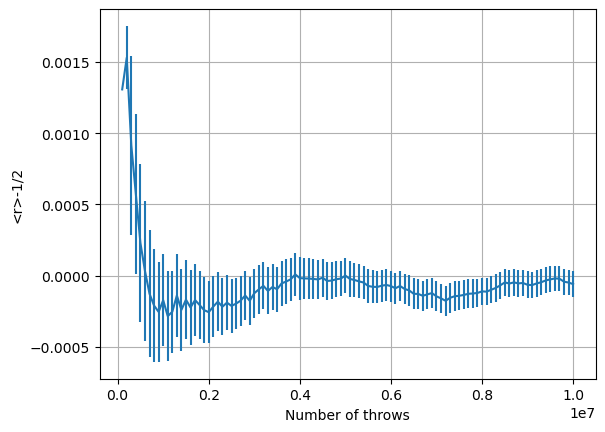

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

n_throws, cum_avg, block_error = np.loadtxt("../data/ex_01.1a.dat", unpack=True, usecols=(0,1,2))

plt.errorbar(n_throws, cum_avg-0.5, yerr=block_error)
plt.xlabel('Number of throws')
plt.ylabel('<r>-1/2')
plt.grid(True)
plt.show()

### Exercise 01.1.2

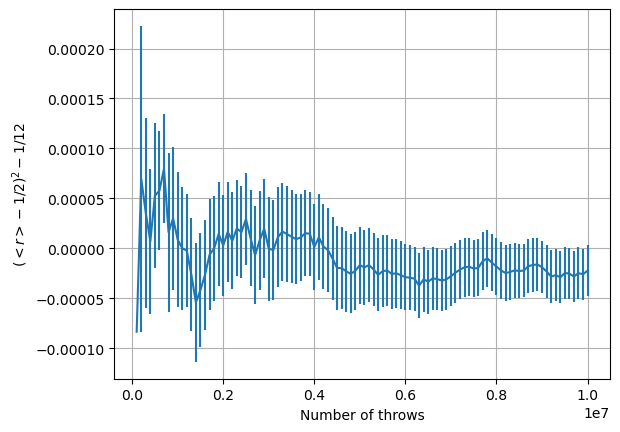

In [19]:
import math

vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex_01.1b.dat", unpack=True, usecols=(0,1,2))

plt.errorbar(vn_throws, vcum_avg-1/12, yerr=vblock_error)
plt.xlabel('Number of throws')
plt.ylabel("$(<r>-1/2)^2 - 1/12$")
plt.grid(True)
plt.show()

### Exercise 01.1.3

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_8909/447951139.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi^2$")


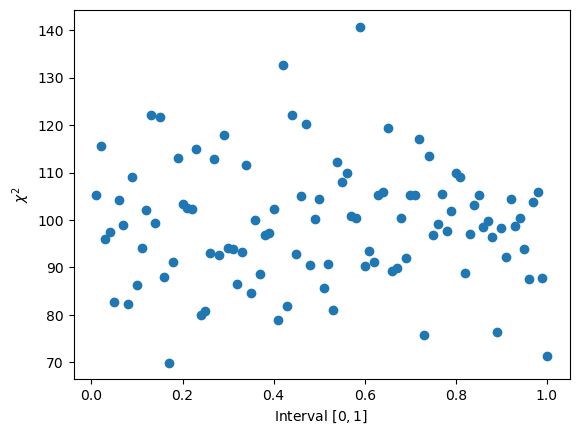

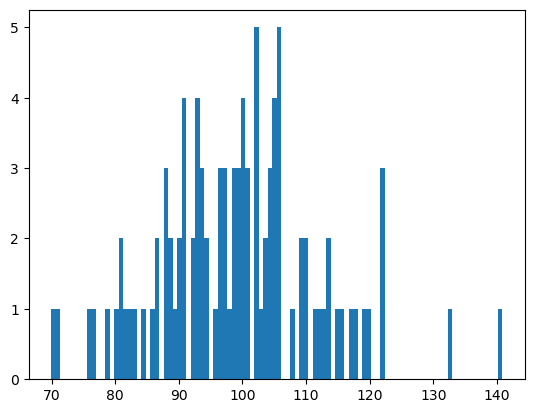

In [21]:
point, chi2 = np.loadtxt("../data/ex_01.1c.dat", unpack=True, usecols=(0,1))

plt.scatter(point*(1/100), chi2)
plt.xlabel("Interval $[0,1]$")
plt.ylabel("$\chi^2$")
plt.show()

plt.hist(chi2, 100)
plt.show()